In [1]:
#import
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import pymysql
import operator
import os
import math
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import *
import scipy.io as sio
import h5py
import copy
import shutil
import rarfile
import random
from general_function import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号
sns.set(style="whitegrid")
myfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)
sns.set(font=myfont.get_name(),style="whitegrid",palette="muted",color_codes=True)

In [2]:
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal
def calc(data):
    n = len(data)
    mu = 0.0
    mu2 = 0.0
    mu3 = 0.0
    for a in data:
        mu += a
        mu2 += a**2
        mu3 += a**3
    mu/= n   #这是求E(X)
    mu2 /= n #这是E(X^2)
    mu3 /= n #这是E(X^3)
    sigma = math.sqrt(mu2 - mu*mu)
    return [mu,sigma,mu3]
def calc_stat(data):
    [mu,sigma,mu3] = calc(data)
    n = len(data)
    mu4 = 0.0
    for a in data:
        a -= mu
        mu4 += a ** 4
    mu4 /= n   
    skew = (mu3 - 3*mu*sigma**2 - mu**3)/(sigma**3)
    kurt =  mu4/(sigma**4)-3
    return [mu,sigma,skew,kurt]

In [3]:
def density_gig(x, lamda, sigma, gamma):
    return (gamma/sigma)**lamda*(x**(lamda-1))/(2*scipy.special.kn(lamda,gamma*sigma))*np.exp(-1/2*(sigma**2*x**-1+gamma**2*x))
def sample_from_gig(lamda, sigma, gamma, size):
    x = np.linspace(0,1,1000000)
    density = density_gig(x, lamda, sigma, gamma)
    density[pd.isnull(density)]=0
    return np.random.choice(x, p = density/density.sum(), size = size)

In [4]:
full_result = pd.read_csv('ghst_density.csv',index_col=0)

In [5]:
Y = stats.norm.rvs(loc=0,scale=1,size=2000)
count = 0
beta_list = np.append(np.linspace(-20,-2,19),np.linspace(2,20,19))
v_list = np.linspace(8.01,10,21)
sigma_list = np.linspace(0.01,0.1,19)

beta_list = np.linspace(-2,2,21)[(np.linspace(-2,2,21)!=-2)&(np.linspace(-2,2,21)!=0)&(np.linspace(-2,2,21)!=2)]
v_list = [8.01]
sigma_list = [0.06]
for beta in beta_list:
    gamma = np.sqrt((np.abs(beta)+0.0001)**2 - beta**2)
    for v in v_list:
        for sigma in sigma_list:
            Z = sample_from_gig(-v/2,sigma,gamma,2000)
            X = beta*Z+np.sqrt(Z)*Y
            result = pd.Series(stats.probplot(X,dist="norm")[0][1],index = stats.probplot(X,dist="norm")[0][0])
            result.name = (beta,v,sigma)
            full_result = pd.concat([full_result,result],axis=1)
        print(count)
        count+=1
full_result.to_csv('ghst_density1.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


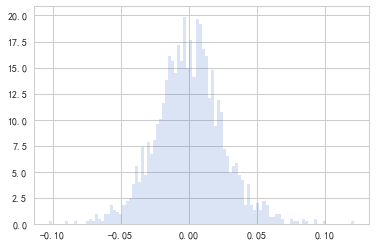

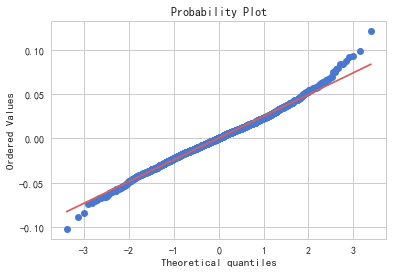

In [6]:
fig, ax = plt.subplots(1, 1)
ax.hist(X, density=True,bins = 100,histtype='stepfilled', alpha=0.2)
plt.show()
stats.probplot(X,dist="norm", plot=plt)
plt.show()